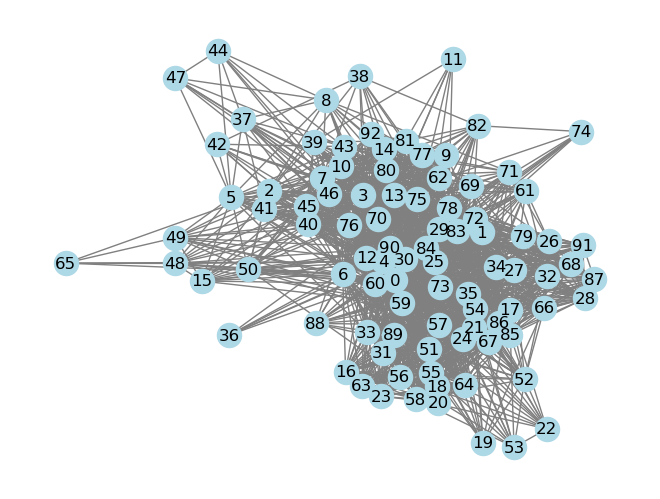

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

A = np.loadtxt("colombiancropmatrix.txt", delimiter="\t")  
G = nx.from_numpy_array(A)
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray")
plt.show()
